# Fitting a Forward Model (Saturation & Concentration Based)
Can we find a forward ML model that can essentially do the simulations for us given the TMPs?

The ultimate goal is to use this forward model as a loss function in inverse modelling. This gives us 2 benefits.
1. Adds an additional loss term to the current inverse model training. This should improve **validation loss/overfitting issues** while making training even better. It can be thought of as a feedback loop.
2. During actual experimentation, we can keep an internal state between different timeframes. A forward model will allow us to generate predictions from this internal state. The goal would be to tie in value consistency within the prediction system. (Think of a Kalman Filter/RNN)

# Things to Try
## 1. Learning the curve-fitting parameters
Curve fitting paramters hold enough information about the entire spatial intensity curve, given the fit is actually good. The hope is that it should be easier for a model to learn 3 x 2 fitting parameters compared to 40 spatial intensity outputs. 

This actually works pretty well. Here are some results
    Model Properties:
        PerceptronBD(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=4, bias=True)
    (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout1d(p=0.2, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=6, bias=True)
    (5): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout1d(p=0.2, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=6, out_features=8, bias=True)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
)
        Optimizer Properties"
        SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.002
    maximize: False
    momentum: 0.9
...
            Validation Method: Holds out fMaternal Wall Thickness columns 0.2182178902359924 for validation. The rest are used for training
        Loss:
            Train Loss: 0.005227597474215039
            Val. Loss: 0.03782471343874931


(PS: The loss is calclated as the MSE over all 6 output parameters, fitting done with weights 1.0, 0.8)

This does not work. The model does learn the curve-fitting paramters pretty well. however, the way those pramters are defined, even a small change actually impacts the output greatly. So, the error curve-fitting domain might not be large but in Spatial intensity doman, the curves are usually absurd. Usually rising exponential curves. This method **DOES NOT** work.

## 2. Learning SI itself(20 pts)


In [15]:
from pathlib import Path
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from inverse_modelling_tfo.data import (
    generate_data_loaders,
    equidistance_detector_normalization,
    constant_detector_count_normalization,
)
from inverse_modelling_tfo.data.intensity_interpolation import (
    interpolate_exp,
    get_interpolate_fit_params,
    exp_piecewise_affine,
)
from inverse_modelling_tfo.data.interpolation_function_zoo import *
from inverse_modelling_tfo.models import RandomSplit, ValidationMethod, HoldOneOut, CVSplit, CombineMethods
from inverse_modelling_tfo.models.custom_models import (
    SplitChannelCNN,
    PerceptronReLU,
    PerceptronBN,
    PerceptronDO,
    PerceptronBD,
    FeatureResidualNetwork
)
from inverse_modelling_tfo.features.build_features import (
    FetalACFeatureBuilder,
    RowCombinationFeatureBuilder,
    TwoColumnOperationFeatureBuilder,
    FetalACbyDCFeatureBuilder,
    LogTransformFeatureBuilder,
    ConcatenateFeatureBuilder,
)
from inverse_modelling_tfo.features.data_transformations import (
    LongToWideIntensityTransformation,
    ToFittingParameterTransformation,
)
from inverse_modelling_tfo.data import config_based_normalization
from inverse_modelling_tfo.data_pipelines.fetal_conc_groups import generate_grouping_from_config
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import torchinfo
from inverse_modelling_tfo.misc.misc_training import set_seed

# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# Load data
in_src = Path(r"/home/rraiyan/simulations/tfo_sim/data/compiled_intensity/dan_iccps_pencil.pkl")
data = pd.read_pickle(in_src)

# Drop Uterus Thickness for now
data = data.drop(columns='Uterus Thickness')

# Normalize data
config_src = in_src.with_suffix(".json")
config_based_normalization(data, config_src)

# Filter a small subset of data for use
## Keep only the first memeber of each Fetal Concentration group
fconc_rounding = 2
grouping_map = generate_grouping_from_config(config_src, fconc_rounding)
groups_to_keep = list(grouping_map.keys())[::3]

data = data[
    (data["Maternal Wall Thickness"] >= 2.0)
    & (data["Maternal Wall Thickness"] <= 12.0)
    & (data["Wave Int"] == 2)
    & (np.round(data["Fetal Hb Concentration"], fconc_rounding).isin(groups_to_keep))
    & (data["Fetal Saturation"] > 0.3)
    & (data["Maternal Saturation"] > 0.95)
]
print("Working with", len(data), "data points")

Working with 604800 data points


In [27]:
data.describe()

,Wave Int,SDD,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,Intensity
count,604800.0,604800.000000,604800.000000,604800.000000,604800.000000,604800.000000,604800.000000,6.048000e+05
mean,2.0,52.450000,8.000000,13.500000,0.977273,13.284848,0.463636,4.955081e-07
std,0.0,25.507814,2.828429,1.569116,0.015526,1.634534,0.090909,2.070789e-06
min,2.0,10.000000,4.000000,11.000000,0.954545,10.450000,0.327273,1.932688e-18
25%,2.0,31.750000,6.000000,12.250000,0.963636,12.069318,0.372727,3.822405e-15
50%,2.0,52.500000,8.000000,13.500000,0.977273,13.256818,0.463636,2.272987e-13
75%,2.0,73.250000,10.000000,14.750000,0.990909,14.532955,0.554545,2.436315e-10
max,2.0,94.000000,12.000000,16.000000,1.000000,16.000000,0.600000,1.357343e-05


In [28]:
# Transofrm to a useable format
# Define data transformers
data_transformer = LongToWideIntensityTransformation()
data = data_transformer.transform(data)

labels = data_transformer.get_label_names()
intensity_columns = data_transformer.get_feature_names()

In [29]:
data.describe()

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,10_2.0,15_2.0,19_2.0,24_2.0,28_2.0,...,55_2.0,59_2.0,64_2.0,68_2.0,72_2.0,77_2.0,81_2.0,86_2.0,90_2.0,94_2.0
count,30240.000000,30240.000000,30240.000000,30240.000000,30240.000000,30240.000000,3.024000e+04,3.024000e+04,3.024000e+04,3.024000e+04,...,3.024000e+04,3.024000e+04,3.024000e+04,3.024000e+04,3.024000e+04,3.024000e+04,3.024000e+04,3.024000e+04,3.024000e+04,3.024000e+04
mean,8.000000,13.500000,0.977273,13.284848,0.463636,0.000009,5.473996e-07,6.236490e-08,5.535108e-09,6.929092e-10,...,3.982063e-13,2.051438e-13,1.064627e-13,5.115061e-14,2.831951e-14,1.323152e-14,7.599449e-15,4.114782e-15,1.774952e-15,1.081346e-15
std,2.828474,1.569141,0.015526,1.634559,0.090911,0.000002,1.870178e-07,2.767251e-08,3.000303e-09,4.033080e-10,...,6.141087e-13,3.118305e-13,1.610203e-13,7.591788e-14,4.416839e-14,2.017060e-14,1.187189e-14,5.872393e-15,2.720421e-15,1.495773e-15
min,4.000000,11.000000,0.954545,10.450000,0.327273,0.000006,2.644472e-07,2.520209e-08,2.113300e-09,2.294026e-10,...,1.709206e-15,3.691207e-16,1.278690e-16,1.429473e-16,1.671112e-16,2.422271e-17,2.029375e-17,4.175189e-18,4.546107e-18,1.932688e-18
25%,6.000000,12.250000,0.963636,12.069318,0.372727,0.000008,3.926288e-07,4.046853e-08,3.196902e-09,3.952050e-10,...,1.413759e-14,6.544954e-15,2.375212e-15,1.156580e-15,7.956711e-16,2.867783e-16,1.503143e-16,7.537629e-17,2.246308e-17,2.449400e-17
50%,8.000000,13.500000,0.977273,13.256818,0.463636,0.000009,5.055990e-07,5.399260e-08,4.517729e-09,5.678995e-10,...,6.402735e-14,3.734626e-14,2.395785e-14,7.655293e-15,4.054667e-15,2.671577e-15,9.202662e-16,9.097205e-16,2.868739e-16,8.057970e-17
75%,10.000000,14.750000,0.990909,14.532955,0.554545,0.000011,6.720246e-07,8.111028e-08,7.204038e-09,8.612506e-10,...,3.825071e-13,2.046775e-13,1.056455e-13,6.041965e-14,2.690837e-14,1.305206e-14,7.582434e-15,5.185808e-15,1.859058e-15,1.817525e-15
max,12.000000,16.000000,1.000000,16.000000,0.600000,0.000014,1.002851e-06,1.370502e-07,1.463137e-08,2.047246e-09,...,2.279593e-12,1.156356e-12,5.966464e-13,2.827272e-13,1.606921e-13,7.394739e-14,4.294191e-14,2.154562e-14,9.878602e-15,5.503227e-15


## Normalizing Features
x_columns will be the input features and y_columns are the target

In [25]:
## Y -> Target
# y_columns = list(filter(lambda X: 'alpha' in X, data.columns))
y_columns = intensity_columns

## X -> Predictors
x_columns = labels

## Scale y
y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

## Scale x
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])

## Model Configuration

In [9]:
IN_FEATURES = len(x_columns)
OUT_FEATURES = len(y_columns)

from inverse_modelling_tfo.models.train_model import ModelTrainerFactory
datagen_kw = {
    'table' : data,
    'data_loader_params' : 
        {
            'batch_size': 64, 'shuffle': True, 'num_workers': 2
        }, 
    'x_columns': x_columns,
    'y_columns': y_columns,
    # Standard Scaling w.r.t. Maternal Wall thickness : The original values are gone. Hold one out for some value
    # in the middle of the pack
    'validation_method' : HoldOneOut('Maternal Wall Thickness', data["Maternal Wall Thickness"].unique()[4])
    # 'validation_method' : HoldOneOut('Maternal Hb Concentration', 13.0)
    # 'validation_method' : HoldOneOut('Maternal Saturation', 1.0)
}

# trainer_factory = ModelTrainerFactory(PerceptronReLU, {'node_counts' : [IN_FEATURES, 8, 2, OUT_FEATURES]}, generate_data_loaders, datagen_kw, 100, nn.MSELoss())
# trainer_factory = ModelTrainerFactory(PerceptronBN, {'node_counts' : [IN_FEATURES, 8, 2, OUT_FEATURES]}, generate_data_loaders, datagen_kw, 100, nn.MSELoss())
# trainer_factory = ModelTrainerFactory(PerceptronDO, {'node_counts' : [IN_FEATURES, 8, 2, OUT_FEATURES]}, generate_data_loaders, datagen_kw, 100, nn.MSELoss())
trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 4, 8, 16, OUT_FEATURES], 'dropout_rates': [0.01, 0.01, 0.01]}, generate_data_loaders, datagen_kw, 100, nn.MSELoss())

## Hyper Parameter Tuning

In [10]:
# Custom Train Function 
def train_with_tuning(iteration_config):
    set_seed(42)
    trainer_tuning = trainer_factory.create()
    trainer_tuning.reporting = True     # Report at each epoch to Ray Tune
    if 'batch_size' in iteration_config:
        trainer_tuning.change_batch_size(iteration_config['batch_size'])    # If batch_size needs tuning
    trainer_tuning.set_optimizer(SGD, {'lr': iteration_config["lr"], 'momentum': iteration_config["momentum"]})
    trainer_tuning.run()

In [18]:
# Hyper Parameter Search 
iteration_config = {
    "lr" : tune.loguniform(1e-5, 1e-3),
    # "batch_size": tune.choice([128, 256]),
    "momentum": tune.uniform(0.8, 0.99),
}
scheduler = ASHAScheduler(metric="combined_loss", mode="min", max_t=60, grace_period=5, reduction_factor=2)
reporter = CLIReporter(metric_columns=["train_loss", "val_loss", "combined_loss", "training_iteration"])
result = tune.run(train_with_tuning, config=iteration_config, scheduler=scheduler, progress_reporter=reporter,
                  num_samples=80, resources_per_trial={"cpu": 0, "gpu": 0.5},)

best_trial = result.get_best_trial("val_loss", "min", "last")
# best_trial = result.get_best_trial("combined_loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(best_trial.last_result["val_loss"]))
print("Best trial final train loss: {}".format(best_trial.last_result["train_loss"]))


2023-11-02 16:13:57,387	INFO tune.py:645 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2023-11-02 16:14:01,182	WARNING worker.py:2058 -- Warning: The actor ImplicitFunc is very large (19 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


== Status ==
Current time: 2023-11-02 16:14:01 (running for 00:00:03.94)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None | Iter 5.000: None
Logical resource usage: 0/64 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_with_tuning_2023-11-02_16-13-57
Number of trials: 70/80 (70 PENDING)




Trial name,combined_loss,train_loss,val_loss
train_with_tuning_7fcaa_00000,0.0042998,0.0593873,0.0724027
train_with_tuning_7fcaa_00001,0.78627,1.00633,0.781322
train_with_tuning_7fcaa_00002,0.916355,1.08623,0.843608
train_with_tuning_7fcaa_00003,0.000785426,0.0250048,0.0314111
train_with_tuning_7fcaa_00004,1.05334,1.19612,0.88063
train_with_tuning_7fcaa_00005,0.00503051,0.0705591,0.071295
train_with_tuning_7fcaa_00006,0.000776379,0.0237362,0.0327086
train_with_tuning_7fcaa_00007,0.875322,1.05849,0.826952
train_with_tuning_7fcaa_00008,0.96395,1.12874,0.854004
train_with_tuning_7fcaa_00009,1.03872,1.1864,0.875525


== Status ==
Current time: 2023-11-02 16:14:06 (running for 00:00:08.97)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None | Iter 5.000: None
Logical resource usage: 0/64 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_with_tuning_2023-11-02_16-13-57
Number of trials: 72/80 (70 PENDING, 2 RUNNING)


== Status ==
Current time: 2023-11-02 16:14:11 (running for 00:00:14.04)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: -0.47201001617545424 | Iter 5.000: -0.8153793250564099
Logical resource usage: 0/64 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_with_tuning_2023-11-02_16-13-57
Number of trials: 72/80 (70 PENDING, 2 RUNNING)


== Status ==
Current time: 2023-11-02 16:14:16 (running for 00:00:19.09)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.0

2023-11-02 16:26:03,655	INFO tune.py:1143 -- Total run time: 726.27 seconds (726.23 seconds for the tuning loop).


== Status ==
Current time: 2023-11-02 16:26:03 (running for 00:12:06.24)
Using AsyncHyperBand: num_stopped=80
Bracket: Iter 40.000: -0.0018283209650871832 | Iter 20.000: -0.003795123658505842 | Iter 10.000: -0.008122486225133237 | Iter 5.000: -0.6733185695200521
Logical resource usage: 0/64 CPUs, 0.5/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_with_tuning_2023-11-02_16-13-57
Number of trials: 80/80 (80 TERMINATED)
+-------------------------------+------------+-----------------------+-------------+------------+--------------+------------+-----------------+----------------------+
| Trial name                    | status     | loc                   |          lr |   momentum |   train_loss |   val_loss |   combined_loss |   training_iteration |
|-------------------------------+------------+-----------------------+-------------+------------+--------------+------------+-----------------+----------------------|
| train_with_tuning_7fcaa_00000 | TERMIN

<!-- Best trial config: {'lr': 0.0010630834634709364, 'b1': 0.4282116859842134, 'b2': 0.3089991262211405, 'batch_size': 8, 'model': [20, 16, 8, 4, 2, 1]}
Best trial final validation loss: 0.09234625198878348
Best trial final train loss: 0.22368373312056064 -->

In [9]:
# best_trial.config

## Custom Training

In [11]:
set_seed(42)
trainer = trainer_factory.create()
# trainer.change_batch_size(16)
# trainer.set_optimizer(SGD, {'lr': best_trial.config['lr'], 'momentum': best_trial.config['lr']["momentum"]})
trainer.set_optimizer(SGD, {'lr': 4e-3, 'momentum': 0.90})
trainer.epochs = 100
trainer.run()

In [11]:
# trainer.epochs = 50
# trainer.run()

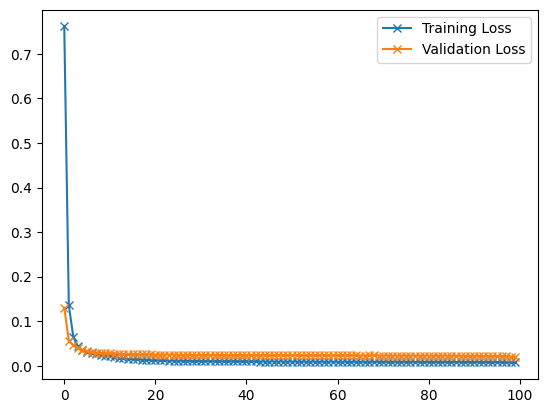

In [12]:
plt.figure()
plt.plot(trainer.train_loss, label='Training Loss', marker='x')
plt.plot(trainer.validation_loss, label='Validation Loss', marker='x')
# plt.yscale('log')
plt.legend()

In [13]:
print(trainer)


        Model Properties:
        PerceptronBD(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=4, bias=True)
    (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout1d(p=0.01, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=8, bias=True)
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout1d(p=0.01, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=16, bias=True)
    (9): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout1d(p=0.01, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=16, out_features=40, bias=True)
    (13): Flatten(start_dim=1, end_dim=-1)
  )
)
        Optimizer Properties"
        SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.004
    maximize: False
    momentum: 0.9
    nesterov: False
    wei

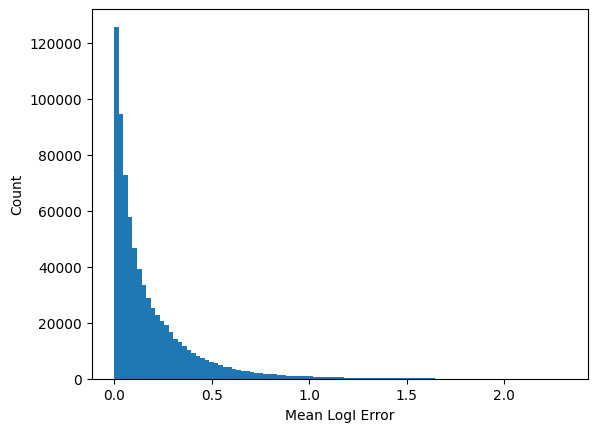

In [15]:
# Get predictions
with torch.no_grad():
    x_data = torch.tensor(data[x_columns].values, dtype=torch.float).cuda()
    predictions = trainer.model(x_data)
    # predictions = fwd_model(x_data)
    predictions = predictions.cpu().numpy()
    predictions = y_scaler.inverse_transform(predictions).flatten()
    y_data = data[y_columns].to_numpy()
    y_data = y_scaler.inverse_transform(y_data).flatten()
    absolute_error = np.abs(y_data - predictions)
    # error_df = pd.DataFrame({'Truth': y_data, "Predicted": predictions, "Absolute Error": absolute_error, "%tage": absolute_error/y_data * 100})
    error_df = pd.DataFrame({'Truth': y_data, "Predicted": predictions, "Absolute Error": absolute_error, "%tage": absolute_error})
plt.figure()
# error_df['%tage'].plot.hist(bins=100)
error_df['Absolute Error'].plot.hist(bins=100)
# plt.xlabel('(%) Error')
plt.xlabel('Mean LogI Error')
plt.ylabel('Count')
plt.show()

In [16]:
# Rough MSE's in percentage
print(f'Train Error(non-normalized): {trainer.train_loss[-1] * y_scaler.var_ }')
print(f'Validation Error(non-normalized): {trainer.validation_loss[-1] * y_scaler.var_ }')

Train Error(non-normalized): [8.39314260e-05 1.88993238e-03 1.00660011e-02 2.42890153e-02
 4.24435009e-02 5.61370689e-02 6.13275892e-02 6.17266001e-02
 6.09416392e-02 6.20454818e-02 6.41816928e-02 6.39128195e-02
 6.84131161e-02 6.71821743e-02 6.53808131e-02 6.54548384e-02
 7.60660773e-02 7.75352391e-02 7.57835951e-02 7.31218923e-02
 2.67175348e-05 4.74914067e-04 9.77547677e-03 3.45419008e-02
 8.80766446e-02 1.37580221e-01 1.66376831e-01 1.53818139e-01
 1.82089026e-01 1.83838288e-01 1.74357632e-01 1.78124999e-01
 1.78893924e-01 1.87990596e-01 2.04475955e-01 1.69213397e-01
 2.03202455e-01 2.09381026e-01 1.94896616e-01 2.54906294e-01]
Validation Error(non-normalized): [2.32079970e-04 5.22587868e-03 2.78336415e-02 6.71618987e-02
 1.17361123e-01 1.55225401e-01 1.69577782e-01 1.70681093e-01
 1.68510586e-01 1.71562837e-01 1.77469704e-01 1.76726239e-01
 1.89170072e-01 1.85766378e-01 1.80785409e-01 1.80990097e-01
 2.10331383e-01 2.14393783e-01 2.09550288e-01 2.02190376e-01
 7.38770322e-05 1.313

In [ ]:
# Model Info
torchinfo.summary(trainer.model)

Layer (type:depth-idx)                   Param #
PerceptronBD                             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       48
│    └─BatchNorm1d: 2-2                  16
│    └─Dropout1d: 2-3                    --
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       108
│    └─BatchNorm1d: 2-6                  24
│    └─Dropout1d: 2-7                    --
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       208
│    └─BatchNorm1d: 2-10                 32
│    └─Dropout1d: 2-11                   --
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      680
│    └─Flatten: 2-14                     --
Total params: 1,116
Trainable params: 1,116
Non-trainable params: 0

In [18]:
model_name = 'forward_curve_fit_paramv2'
import joblib
# Save Model
torch.save(trainer.model.state_dict(), rf'../models/{model_name}')
# Save the Scalers for Later Use
joblib.dump(x_scaler, rf'../models/{model_name}_xscaler')
joblib.dump(y_scaler, rf'../models/{model_name}_yscaler')

['../models/forward_curve_fit_paramv2_yscaler']

In [ ]:
# # Load Model Code
# import joblib
# model_name = 'forward_curve_fit_paramv1'
# fwd_model = PerceptronBD([5, 6, 8, 8], dropout_rates = [0.2, 0.2])
# fwd_model.load_state_dict(torch.load(rf'../models/{model_name}'))
# fwd_model = fwd_model.cuda()
# fwd_model = fwd_model.eval()
# # The input TMPs will already be scaled. No need to further use an x_scaler
# y_scaler_fwd = joblib.load(rf'../models/{model_name}_yscaler')
# x_scaler_fwd = joblib.load(rf'../models/{model_name}_xscaler')